# Module 3 - Programming Assignment

## Directions

1. Change the name of this file to be your JHED id as in `jsmith299.ipynb`. Because sure you use your JHED ID (it's made out of your name and not your student id which is just letters and numbers).
2. Make sure the notebook you submit is cleanly and fully executed. I do not grade unexecuted notebooks.
3. Submit your notebook back in Blackboard where you downloaded this file.

*Provide the output **exactly** as requested*

## k Nearest Neighbors and Model Evaluation

In this programming assignment you will use k Nearest Neighbors (kNN) to build a "model" that will estimate the compressive strength of various types of concrete. This assignment has several objectives:

1. Implement the kNN algorithm with k=9. Remember...the data + distance function is the model in kNN. In addition to asserts that unit test your code, you should "test drive" the model, showing output that a non-technical person could interpret.

2. You are going to compare the kNN model above against the baseline model described in the course notes (the mean of the training set's target variable). You should use 10 fold cross validation and Mean Squared Error (MSE):

$$MSE = \frac{1}{n}\sum^n_i (y_i - \hat{y}_i)^2$$

as the evaluation metric ("error"). Refer to the course notes for the format your output should take. Don't forget a discussion of the results.

3. use validation curves to tune a *hyperparameter* of the model. 
In this case, the hyperparameter is *k*, the number of neighbors. Don't forget a discussion of the results.

4. evaluate the *generalization error* of the new model.
Because you may have just created a new, better model, you need a sense of its generalization error, calculate that. Again, what would you like to see as output here? Refer to the course notes. Don't forget a discussion of the results. Did the new model do better than either model in Q2?

5. pick one of the "Choose Your Own Adventure" options.

Refer to the "course notes" for this module for most of this assignment.
Anytime you just need test/train split, use fold index 0 for the test set and the remainder as the training set.
Discuss any results.

## Load the Data

The function `parse_data` loads the data from the specified file and returns a List of Lists. The outer List is the data set and each element (List) is a specific observation. Each value of an observation is for a particular measurement. This is what we mean by "tidy" data.

The function also returns the *shuffled* data because the data might have been collected in a particular order that *might* bias training.

In [1]:
import random
random.seed(10)
import copy
from typing import List, Dict, Tuple, Callable

In [2]:
def parse_data(file_name: str) -> List[List]:
    data = []
    file = open(file_name, "r")
    for line in file:
        datum = [float(value) for value in line.rstrip().split(",")]
        data.append(datum)
    random.shuffle(data)
    return data

In [3]:
data = parse_data("concrete_compressive_strength.csv")

In [4]:
data[0]

[425.0, 106.3, 0.0, 153.5, 16.5, 852.1, 887.1, 7.0, 49.2]

In [5]:
len(data)

1030

There are 1,030 observations and each observation has 8 measurements. The data dictionary for this data set tells us the definitions of the individual variables (columns/indices):

| Index | Variable | Definition |
|-------|----------|------------|
| 0     | cement   | kg in a cubic meter mixture |
| 1     | slag     | kg in a cubic meter mixture |
| 2     | ash      | kg in a cubic meter mixture |
| 3     | water    | kg in a cubic meter mixture |
| 4     | superplasticizer | kg in a cubic meter mixture |
| 5     | coarse aggregate | kg in a cubic meter mixture |
| 6     | fine aggregate | kg in a cubic meter mixture |
| 7     | age | days |
| 8     | concrete compressive strength | MPa |

The target ("y") variable is a Index 8, concrete compressive strength in (Mega?) [Pascals](https://en.wikipedia.org/wiki/Pascal_(unit)).

## Train/Test Splits - n folds

With n fold cross validation, we divide our data set into n subgroups called "folds" and then use those folds for training and testing. You pick n based on the size of your data set. If you have a small data set--100 observations--and you used n=10, each fold would only have 10 observations. That's probably too small. You want at least 30. At the other extreme, we generally don't use n > 10.

With 1,030 observations, n = 10 is fine so we will have 10 folds.
`create_folds` will take a list (xs) and split it into `n` equal folds with each fold containing one-tenth of the observations.

In [6]:
def create_folds(xs: List, n: int) -> List[List[List]]:
    k, m = divmod(len(xs), n)
    # be careful of generators...
    return list(xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [7]:
folds = create_folds(data, 10)

In [8]:
len(folds)

10

We always use one of the n folds as a test set (and, sometimes, one of the folds as a *pruning* set but not for kNN), and the remaining folds as a training set.
We need a function that'll take our n folds and return the train and test sets:

In [9]:
def create_train_test(folds: List[List[List]], index: int) -> Tuple[List[List], List[List]]:
    training = []
    test = []
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = training + fold
    return training, test

We can test the function to give us a train and test datasets where the test set is the fold at index 0:

In [10]:
train, test = create_train_test(folds, 0)

In [11]:
len(train)

927

In [12]:
len(test)

103

## Answers

Answer the questions above in the space provided below, adding cells as you need to.
Put everything in the helper functions and document them.
Document everything (what you're doing and why).
If you're not sure what format the output should take, refer to the course notes and what they do for that particular topic/algorithm.

## Problem 1: kNN

Implement k Nearest Neighbors with k = 9.

In order to test for the computations below, I will use the example provided in the Self Check under problem 1 for this module. 


| # 	| x1   	| x2   	| y    	| Euclidean Distance 	|
|---	|------	|------	|------	|--------------------	|
| 1 	| 0.23 	| 0.81 	| 0.18 	| 0.24083            	|
| 2 	| 0.42 	| 0.78 	| 0.33 	| 0.15297            	|
| 3 	| 0.64 	| 0.23 	| 0.14 	| 0.4717             	|
| 4 	| 0.87 	| 0.19 	| 0.17 	| 0.65115            	|
| 5 	| 0.76 	| 0.43 	| 0.32 	| 0.42059            	|
| 6 	| 0.39 	| 0.63 	|      	|                    	|

### Computing the Euclidean Distance
The formula for euclidean distance is:
$$
\text{Euclidean Distance} = \sqrt{\sum_{i=1}^N (q_{i}-p_{i})^2}
$$
The function `euclidean_distance` below takes in two lists for which the euclidean distance is computed. It loops component wise while calculating and squaring the distances. Each distance is added to the distance variable. Finally the we compute the squared root of the aggregate distance and return this quantity. 

In [13]:
def euclidean_distance(x_1: list, x_2: list) ->float:
    distance = 0
    for i in list(zip(x_1, x_2)):
        distance += (i[0] - i[1])**2
    distance= distance ** 0.5
    return distance        

In [14]:
x1 = [[0.23,0.81],[0.42,0.78],[0.64,0.23],[0.87,0.19],[0.76,0.43]]
x2 = [0.39,0.63]
assert euclidean_distance(x1[0],x2) == 0.24083189157584595
assert euclidean_distance(x1[1],x2) == 0.15297058540778355
assert euclidean_distance(x1[2],x2) == 0.47169905660283024
assert euclidean_distance(x1[3],x2) == 0.6511528238439882
assert euclidean_distance(x1[4],x2) == 0.4205948168962618

### Creating a distances list
In order to implement k-Nearest Neighbor I will generate a sorted list of tuples. Each tuple in the list will contain:
1. The euclidean distance against of the observation against the observation for which we want to predict the target variable
2. The explanatory or features of the observation, that is variables 0,7 from the data.
3. The target variable for the particular observation, that is the concrete compressive strength.
We will build and sort this list as the calculations are computed. For this, I have created three functions.
    1. `create_distance_list()` takes in the data along with the observation to be compared with as `x_1` and `x_2` respectively. The function returns a list of lists. Each list entry of the list has the following combination `[distance, x_1, y]` which represent the value of the euclidean distance, the features for that particular point, and finally the observed `y` value for that observation.
    2. `add_distances_list()` creates or adds observations to a list of lists. Knowing that we will only need the closest $k$ observations, it makes a lot of sense to keep a sorted list by the euclidean distances. `add_distances_list()` populates a list in ascending distance order. That is, the closest points remain ahead in then list. This will ensure that we only need to consult this list once and will only need to get the first $k$ observations to generate our estimated predicted $\hat{y}$ value.

In [15]:
def create_distance_list(x_1: list, x_2: list) -> list:
    x_1 = x_1.copy()
    x_2 = x_2.copy()
    y = x_1.pop(-1)
    distance = euclidean_distance(x_1, x_2)
    distance_tuple = [distance, x_1, y]
    return distance_tuple  

In [16]:
x1 = [[0.23,0.81,0.18],[0.42,0.78,0.33],[0.64,0.23,0.14],[0.87,0.19,0.17],[0.76,0.43,0.32]]
x2 = [0.39,0.63]
# compute the distances in the format required above
assert create_distance_list(x1[0], x2) == [0.24083189157584595, [0.23, 0.81], 0.18]
assert create_distance_list(x1[1], x2) == [0.15297058540778355, [0.42, 0.78], 0.33]
assert create_distance_list(x1[2], x2) == [0.47169905660283024, [0.64, 0.23], 0.14]
assert create_distance_list(x1[3], x2) == [0.6511528238439882, [0.87, 0.19], 0.17]
assert create_distance_list(x1[4], x2) == [0.4205948168962618, [0.76, 0.43], 0.32]

In [17]:
def add_distances_list(distance_list: list, distances_list: list):
    if len(distances_list)==0:
        distances_list.append(distance_list)
        return None
    else:
        for i in range(len(distances_list)):
            if distance_list[0] < distances_list[i][0]:
                distances_list.insert(i, distance_list)
                return None
    distances_list.append(distance_list)
    return None  

In [18]:
distances_list = []
for i in range(len(x1)):
    distance_list = create_distance_list(x1[i], x2)
    add_distances_list(distance_list, distances_list)
# take the distances computed above and should return an organized list by distances 
assert distances_list == [[0.15297058540778355, [0.42, 0.78], 0.33],
                          [0.24083189157584595, [0.23, 0.81], 0.18],
                          [0.4205948168962618, [0.76, 0.43], 0.32],
                          [0.47169905660283024, [0.64, 0.23], 0.14],
                          [0.6511528238439882, [0.87, 0.19], 0.17]]

### k-nearest neightbors prediction
At this point we have created a list sorted by euclidean distances. Now, in order to finish up the procedure we simply need to take an average of the target variable of closest $k$ observations. To that end, I have created two functions:
1. `mean()` takes a list of floats and returns the average value for all observations.
2. `knn_regression(x_1, x_2, k)` is a wrapper function of the functions generated up to now, that is: `distance_list()`,`add_distances_list()`, and `mean()`. It takes as parameters the features data `x_1`, the sample observation for which we will produce the predicted `y_hat` value, and the parameter `k` which corresponds to the number of neighbors to be considered. By using the aforementioned functions, `knn_regression(x_1, x_2, k)` produces the `k_closest` points in the whole sample data and computes the mean of the `y` values on those as the `y_hat` observation for that particular `x_2`.

In [19]:
def mean(list_: list) -> float:
    list_ = list_.copy()
    sum_ = 0
    for i in list_:
        sum_ += i
    mean = sum_ / len(list_)
    return mean

In [20]:
assert mean([1,2,3,4,5]) == 3
assert mean([0,1,0,1,0,1]) == 0.5

In [21]:
def knn_regression(x_1, x_2, k):
    distances_list = []
    for i in range(len(x_1)):
        distance_list = create_distance_list(x_1[i], x_2)
        add_distances_list(distance_list, distances_list)
    k_closest = [distance[-1] for distance in distances_list[:k]]
    knn_prediction = mean(k_closest)
    return knn_prediction

In [22]:
# produce the knn_regression values as per the Self Check
assert knn_regression(x1, x2, 1) == 0.33
assert knn_regression(x1, x2, 2) == 0.255
assert knn_regression(x1, x2, 3) == 0.27666666666666667

### k-nearest neightbors prediction for $k=9$:
Now that we have all of our functions, we can produce the k-nearest neighbor regression value for the first observation of the data. The predicted value is $39.72$ vs the actual $y$ value of  $49.2$.

In [23]:
knn_data = copy.deepcopy(data)
sample = knn_data.pop(0)
knn_regression(knn_data, sample, 9)

49.30777777777779

### Illustrating knn to a non-technical person

K-nearest consists in trying to either classify or predict the value of a particular observation. I am going to use, once again, the data from the Self-Check to illustrate the behavior of the algorithm. 

Suppose you have the points below in a three dimensional plane. We would like to find out a reasonable value of the y coordinate on the 6th observation, as we are not provided with one. In order to do so, we will consider those points which are most similar to 6 from the other 5 points. That is, we would like to come up with a reasonable y coordinate for 6, given that we have information on 5 other points and some of which are similar to 6. We will use those similar points to infer the y coordinate of 6.

| # 	| x1   	| x2   	| y    	| 
|---	|------	|------	|------	|
| 1 	| 0.23 	| 0.81 	| 0.18 	| 
| 2 	| 0.42 	| 0.78 	| 0.33 	| 
| 3 	| 0.64 	| 0.23 	| 0.14 	| 
| 4 	| 0.87 	| 0.19 	| 0.17 	| 
| 5 	| 0.76 	| 0.43 	| 0.32 	| 
| 6 	| 0.39 	| 0.63 	| ?    	| 

Let's look at how similar these points are in the $x_1$-$x_2$ plane:

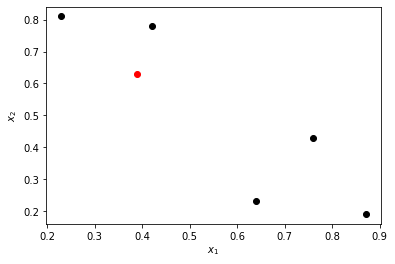

In [24]:
import matplotlib.pyplot as plt
points = [[0.23,0.81],[0.42,0.78],[0.64,0.23],[0.87,0.19],[0.76,0.43],[0.39,0.63]]
for i in points[:5]:    
    plt.scatter(i[0],i[1], c='black')
plt.scatter(points[5][0],points[5][1], c='red')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

Above we have plotted the $x_1$ and $x_2$ coordinates, the red dot corresponds to the observation for which we would like to predict a $y$ coordinate value. From this picture we can see that the points that are most similar (or closest) could be the ones at the top left corner of the graph. In fact, there is a point which is in particular closest. With k-nearest neighbor, we will select the $y$ values for those $k$ points which are the most similar (closest), and use them to predict a value for the $y$ coordinate on the red dot. 

In order to determine similarity we will use a metric called Euclidean Distance. The mathematics of Euclidean Distance are not particularly complex but what is really important to understand is that Euclidean Distance gives us a numeric value for how close the coordinates on each direction (axis) are as a whole. 

Now, imagine that we would like to select the $k=3$ closest neighbors among the 5 provided. Euclidean Distance provides us with the closest dots, in the graph below I have marked the three closest dots with a blue color

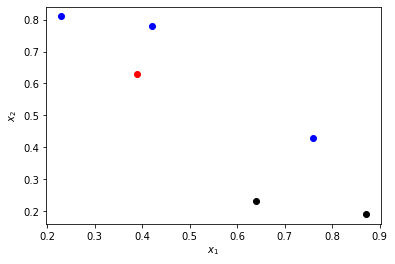

In [25]:
plt.scatter(points[0][0],points[0][1], c='blue')
plt.scatter(points[1][0],points[1][1], c='blue')
plt.scatter(points[2][0],points[2][1], c='black')
plt.scatter(points[3][0],points[3][1], c='black')
plt.scatter(points[4][0],points[4][1], c='blue')
plt.scatter(points[5][0],points[5][1], c='red')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

The points in blue above are the closest by Euclidean Distance, the k-nearest neighbor prediction will be generated by taking the average value of their corresponding $y$ coordinate values. The coordinates for those three points are $\{0.23,0.81,0.18\}$, $\{0.42,0.78,0.33\}$, and $\{0.76,0.46,0.32\}$, where the coordinates are mapped as $\{x_1,x_2,y\}$. The average $y$ for these three "selected" points is $0.2766$. This average value will be our estimated $y$ coordinate for point 6. Therefore, our table becomes

| # 	| x1   	| x2   	| y    	| 
|---	|------	|------	|------	|
| 1 	| 0.23 	| 0.81 	| 0.18 	| 
| 2 	| 0.42 	| 0.78 	| 0.33 	| 
| 3 	| 0.64 	| 0.23 	| 0.14 	| 
| 4 	| 0.87 	| 0.19 	| 0.17 	| 
| 5 	| 0.76 	| 0.43 	| 0.32 	| 
| 6 	| 0.39 	| 0.63 	| **0.276**	| 

Plotting this into a three dimmension plot, we get

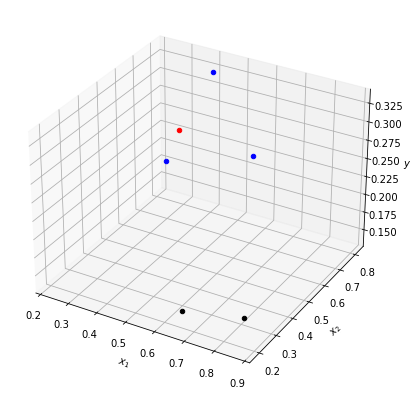

In [26]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(0.23, 0.81, 0.18, color = "blue")
ax.scatter3D(0.42, 0.78, 0.33, color = "blue")
ax.scatter3D(0.64, 0.23, 0.14, color = "black")
ax.scatter3D(0.87, 0.19, 0.17, color = "black")
ax.scatter3D(0.76, 0.43, 0.32, color = "blue")
ax.scatter3D(0.39, 0.63, 0.276, color = "red")
ax.set_xlabel('$x_1$', fontweight ='bold')
ax.set_ylabel('$x_2$', fontweight ='bold')
ax.set_zlabel('$y$', fontweight ='bold')
plt.show()

From the plot above we have illustrated how k-nearest neighbor has allowed us to generate an estimate value for the $y$ coordinate of point 6. Below we test drive the functions we have generated in this section to check that all the computations follow this logic.

In [27]:
x1 = [[0.23,0.81,0.18],[0.42,0.78,0.33],[0.64,0.23,0.14],[0.87,0.19,0.17],[0.76,0.43,0.32]]
x2 = [0.39,0.63]
knn_regression(x1, x2, 3)

0.27666666666666667

## Problem 2: Evaluation vs. The Mean

Using Mean Squared Error (MSE) as your evaluation metric, evaluate your implement above and the Null model, the mean.

### Mean Squared Error
First we need to define the Mean Squared Error (MSE) function. The MSE function is defined as 
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (\hat{y}_i-y_i)^2
$$
The function `mean_squared_error()` takes as parameters two lists and produces the MSE for the two lists, computing element wise differences, squaring them, and then taking their mean. The mean is computed using the `mean()` function defined previously.

In [28]:
def mean_squared_error(y, y_hat):
    squared_error = []
    for y_i, y_hat_i in list(zip(y, y_hat)):
        squared_error.append((y_hat_i - y_i)**2)
    mean_squared_error = mean(squared_error)        
    return mean_squared_error

In [29]:
y = [0,1,2,3,4,5,6]
y_hat = [6,5,4,3,2,1,0]
assert mean_squared_error(y, y_hat) == 16

y = [0,1,0,1,0,1]
y_hat = [1,0,1,0,1]
assert mean_squared_error(y, y_hat) == 1

### Computing the baseline model
In order to compare the KNN model specified in part 2, or the case when $k=9$. We will use the mean of the training set's target variable as comparison and baseline. We will also implement 10 fold cross validation and Mean Squared Error (MSE) as specified in `create_train_test()` and `mean_squared_error(y, y_hat)`.
In order to achieve this, we will loop through each fold. For each fold we will:
1. Compute the baseline model prediction by computing the mean y value of the training set.
2. Compute the MSE of the baseline prediction against the actual test set y values.
3. Compute the actual knn (k=9) predicted value. It is important to note that we are using the training data for sampling and producing the y-hats but the actual observations we are regressing are those in the test set. 
4. We compute the MSE for each cross validation fold.
5. Finally we print the results in a table and also provide the mean value of the cross validations' Mean Squared Errors for both the baseline model and the knn(k=9) model.

In [30]:
mse_base_list = []
mse_knn_list = []
folds = create_folds(data, 10)
fold_label = 'Fold'
knn_mse_label = 'KNN MSE'
base_mse_label = 'Base MSE'
mean_label = "Mean"
print(f"""{fold_label : <5}{knn_mse_label : ^15}{base_mse_label : >10}""")
for i in range(len(folds)):
    train, test = create_train_test(folds, i)    
    y = [sample[-1] for sample in test]       
    
    base_y_hat = [sample[-1] for sample in train]
    base_y_hat = mean(base_y_hat)    
    mse_base = mean_squared_error([base_y_hat]*len(y), y)
    mse_base_list.append(mse_base)
    
    knn_y_hat = [knn_regression(train, test[i], 9) for i in range(len(test)-1)]
    mse_knn = mean_squared_error(knn_y_hat, y)
    mse_knn_list.append(mse_knn)
    print(f"""{i+1 : <5}{mse_knn : ^15.4f}{mse_base : >10.4f}""")

print(f"""{mean_label : <5}{mean(mse_knn_list) : ^15.4f}\
{mean(mse_base_list) : >10.4f}""")

Fold     KNN MSE      Base MSE
1       101.2509      262.3220
2        65.5449      278.5835
3        87.4633      253.5430
4       105.2789      283.3392
5        98.1099      272.0312
6        95.5514      292.8178
7        84.7436      302.5182
8        73.5014      235.8173
9        84.4274      294.7390
10      117.2592      318.8422
Mean     91.3131      279.4553


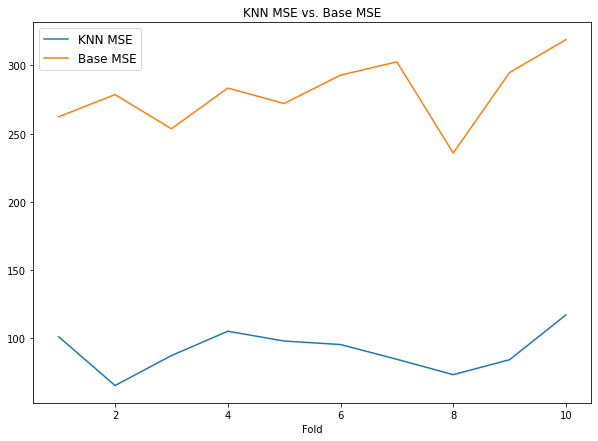

In [31]:
fig = plt.figure(figsize=(10, 7))
plt.plot(range(1,11),mse_knn_list, label='KNN MSE')
plt.plot(range(1,11),mse_base_list, label = 'Base MSE')
plt.xlabel("Fold")
plt.legend(fontsize=12)
plt.title('KNN MSE vs. Base MSE')
plt.show()

### Interpretation of results
Our KNN model shows significant MSE improvement over the baseline model. This happens both in each individual fold as well as the mean MSE results. The graph above provides a clear depiction of the improvement generated from using the knn(k=9) model versus the baseline model. It is important to denote moving forward that we prefer a lower MSE, that means that when reading the graphs, a lower MSE value is better than a higher MSE value.

## Problem 3: Hyperparameter Tuning

Tune the value of k.

### `evaluate()` function
In keeping with the course notes, we will follow the pseudo-code provided in order to generate validation curves. To that end I have implemented the `evaluate()` function. `evaluate()` takes in the `model` which corresponds to the knn regression; `evalutation` corresponds to the cost function which is in this case MSE; `train` is the training set; `test` when appropriate is the test set; and finally the `hyperparameter` to test.
I will use this function to loop through different $k$ hyperparameter values to test and will compute MSE statistics both on the training set, as well as the test set using the training set for prediction.

In [32]:
def evaluate(model: callable, evaluation: callable, train: list, test: list, hyperparameter: int):
    y_hat = []
    y = []
    if test is None:
        for i in range(len(train)):
            data_copy = train.copy()
            sample = data_copy.pop(i)
            y_hat.append(model(data_copy, sample, hyperparameter))
            y.append(sample[-1])
        evaluation_value = evaluation(y_hat, y)
    else:
        for i in range(len(test)):
            data_copy = train.copy()
            sample = test[i]
            y_hat.append(model(data_copy, sample, hyperparameter))
            y.append(sample[-1])
        evaluation_value = evaluation(y_hat, y) 
    return evaluation_value

In [33]:
# using the Self Check data we can check the MSE produced
assert evaluate(knn_regression,mean_squared_error,x1,None,3) == 0.011684444444444445

In [34]:
train_mse_list = []
test_mse_list = []
k_range = range(1,25)
k_label = 'K'
training_label = 'Training MSE'
test_label = 'Test MSE'
mean_label = "Mean"
print(f"""{k_label : <5}{training_label : ^15}{test_label : >10}""")
for k in k_range:
    train, test = create_train_test(folds, 0)
    
    # compute training knn
    train_mse = evaluate(knn_regression,mean_squared_error,train,None,k)
    train_mse_list.append(train_mse)
    
    # compute training knn
    test_mse = evaluate(knn_regression,mean_squared_error,train,test,k)
    test_mse_list.append(test_mse)
    
    print(f"""{k : <5}{train_mse : ^15.4f}{test_mse : >10.4f}""")
    
print(f"""{mean_label : <5}{mean(train_mse_list) : ^15.4f}\
{mean(test_mse_list) : >10.4f}""")

K     Training MSE    Test MSE
1        77.6845       68.8143
2        79.6484       68.2664
3        76.0530       71.3869
4        77.9005       71.0259
5        81.2431       72.7645
6        81.9068       78.6297
7        84.9855       84.1299
8        86.0835       92.1410
9        87.0801      100.2702
10       89.2377      102.3496
11       91.3533      103.4688
12       93.9367      106.7680
13       94.9467      106.5150
14       96.1221      103.9755
15       97.7528      105.7791
16       98.8605      108.0895
17      101.1772      110.2578
18      104.0471      115.1665
19      105.8599      119.2254
20      108.1113      124.9322
21      109.5508      125.9410
22      112.0052      128.8800
23      113.6571      131.3421
24      114.6750      131.8376
Mean     94.3283      101.3315


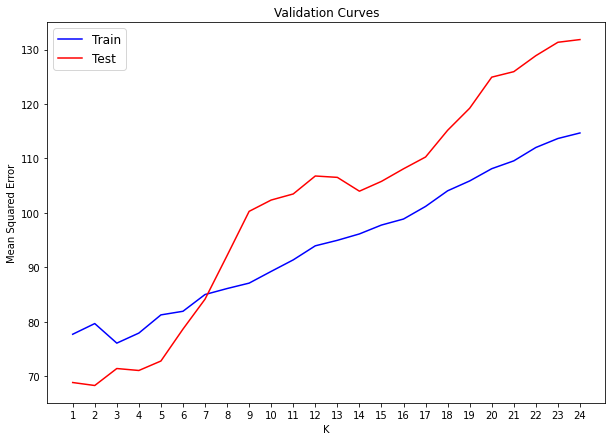

In [35]:
fig = plt.figure(figsize=(10, 7))
plt.plot(k_range,train_mse_list, c='blue', label='Train')
plt.plot(k_range,test_mse_list, c='red', label='Test')
plt.xlabel("K")
plt.xticks(k_range)
plt.ylabel("Mean Squared Error")
plt.legend(fontsize=12)
plt.title('Validation Curves')
plt.show()

### Interpreting the validation curves
I have previously mentioned that we would prefer lower MSE values. It is important also to understand the mechanics of knn by virtue of its definition. As $k$ increases, the number of observations used to derive a particular predicted value increases. This means that the algorithm is looking outward into observations further out (or less similar) to those closest. Because of this, it is no surprise that MSE increases as $k$ increases. For this data, it seems as though the gap between the test and training data stabilizes for higher $k$. Because of this particular characteristic, I would prefer to stay within $k<10$.

In the course notes it is indicated that in general we should pick the value of the hyperparameter where the test validation curve has a minimum. In this case that happens at $k=2$. It is also among the lower values for the training set. Therefore we will choose $k=2$ moving forward as our $k$ of choice.

## Problem 4: Generalization Error

Analyze and discuss the generalization error of your model with the value of k from Problem 3.

### Generalization for $k=2$
Below I implement the same code we did for problem 2, this time using $k=2$. We want to compare is using this hyperparameter will serve to improve the MSE scores for the cross-validation across 10 folds.

In [36]:
mse_base_list = []
mse_knn_list = []
folds = create_folds(data, 10)
fold_label = 'Fold'
knn_mse_label = 'KNN MSE'
base_mse_label = 'Base MSE'
mean_label = "Mean"
print(f"""{fold_label : <5}{knn_mse_label : ^15}{base_mse_label : >10}""")
for i in range(len(folds)):
    train, test = create_train_test(folds, i)    
    y = [sample[-1] for sample in test]       
    
    base_y_hat = [sample[-1] for sample in train]
    base_y_hat = mean(base_y_hat)    
    mse_base = mean_squared_error([base_y_hat]*len(y), y)
    mse_base_list.append(mse_base)
    
    knn_y_hat = [knn_regression(train, test[i], 2) for i in range(len(test)-1)]
    mse_knn = mean_squared_error(knn_y_hat, y)
    mse_knn_list.append(mse_knn)
    print(f"""{i+1 : <5}{mse_knn : ^15.4f}{mse_base : >10.4f}""")

print(f"""{mean_label : <5}{mean(mse_knn_list) : ^15.4f}\
{mean(mse_base_list) : >10.4f}""")

Fold     KNN MSE      Base MSE
1        68.8999      262.3220
2        71.5046      278.5835
3       102.7091      253.5430
4        86.5475      283.3392
5        67.7506      272.0312
6       101.6776      292.8178
7        88.4393      302.5182
8        75.1224      235.8173
9        60.9490      294.7390
10       70.6211      318.8422
Mean     79.4221      279.4553


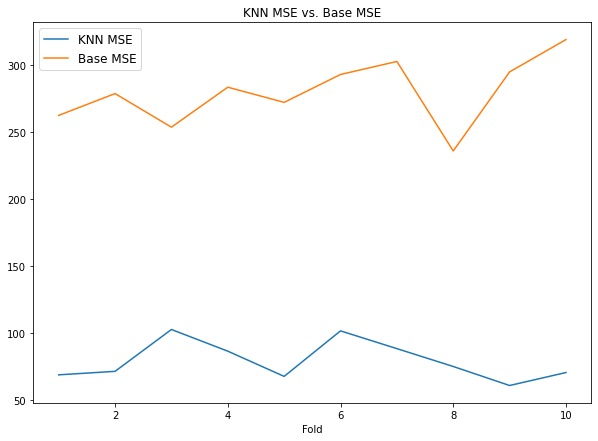

In [37]:
fig = plt.figure(figsize=(10, 7))
plt.plot(range(1,11),mse_knn_list, label='KNN MSE')
plt.plot(range(1,11),mse_base_list, label = 'Base MSE')
plt.xlabel("Fold")
plt.legend(fontsize=12)
plt.title('KNN MSE vs. Base MSE')
plt.show()

### Interpretation
Recall that in part 2 we indicated that Knn outperformed significantly the baseline model. It is also the case that the $k=2$ model outperforms the $k=9$ model. The mean MSE score for $k=2$ is $79.4221$, compared to $91.3131$ in the case of $k=9$. This is a significant improvement that is consistent across the different folds. 

## Q5: Choose your own adventure

You have three options for the next part:

1. You can implement mean normalization (also called "z-score standardization") of the *features*; do not normalize the target, y. See if this improves the generalization error of your model (middle).

2. You can implement *learning curves* to see if more data would likely improve your model (easiest).

3. You can implement *weighted* kNN and use the real valued GA to choose the weights. weighted kNN assigns a weight to each item in the Euclidean distance calculation. For two points, j and k:
$$\sqrt{\sum w_i (x^k_i - x^j_i)^2}$$

You can think of normal Euclidean distance as the case where $w_i = 1$ for all features  (ambitious, but fun...you need to start EARLY because it takes a really long time to run).

The easier the adventure the more correct it must be...

### Choosing path 2
I have chosen path 2, this involves normalizing all of the features on the trainings and test data in order to produce a better prediction. 
Normalization, at least as described in the problem requires z-score normalization. z-score normalization is denoted by the following formula:
$$
Z = \frac{X - \bar{x}}{\sigma}
$$
Where $X$ corresponds to a vector (column) of data, $\bar{x}$ corresponds to the mean value of the vector as previously implemented, and $\sigma$ corresponds to the standard deviation of the column. $\sigma$ for a sample is given by
$$
\sigma = \sqrt{\frac{\sum_{i=1}^n (x_i - \bar{x})^2}{n-1}}
$$

To this end, I have implemented the following functions:
1. `means()` takes the training data and returns the data in column form as well as a list of the mean values per column (feature). 
2. `standard_deviations(column_data, mean_values)` takes in the data formated in columns from the previous function as well as the mean values and returns a list of the column standard deviations.
3. `z_score_normalization(data, mean_values, sds)` takes in the `data` that we want to normalize along with the `mean_values` and `sds` (standard deviation) lists. The function only transforms the features and does not transform the target values. This function returns normalized features on the data.



In [38]:
def means(data):
    data_copy = copy.deepcopy(data)
    columns = [[] for i in range(len(data_copy[0]))]
    for row in range(len(data_copy)):
        for col in range(len(data_copy[row])):
            columns[col].append(data_copy[row][col])
    mean_values = [mean(columns[col]) for col in range(len(columns))]
    return columns, mean_values

In [39]:
# using the x_1 data from the self check to validate the means
columns, mean_values = means(x1)
assert mean_values == [0.584, 0.4880000000000001, 0.22800000000000004]

In [40]:
def standard_deviations(column_data, mean_values):
    sds = []
    for col in range(len(column_data)):
        column = column_data[col]
        sd = 0
        n = 0
        for row in range(len(column)):
            sd += (column[row] - mean_values[col])**2
            n += 1
        sd = (sd / (n-1))**0.5
        sds.append(sd)
    return sds

In [41]:
sds = standard_deviations(columns, mean_values)
assert sds == [0.25890152568109753, 0.29482198018465317, 0.08983317872590282]

In [42]:
def z_score_normalization(data, mean_values, sds):    
    data_copy = copy.deepcopy(data)
    targets = []
    for row in range(len(data_copy)):
        target = data_copy[row].pop(-1)
        for col in range(len(data_copy[row])):
            data_copy[row][col] = (data_copy[row][col] - mean_values[col]) / sds[col]
        data_copy[row].append(target)
    return data_copy       

In [43]:
# normalize the data, notice that each feature column has a mean of 0 and standard deviation of 1.
# also notice that the target variable has not been modified
assert z_score_normalization(x1, mean_values, sds) == [[-1.3673152333448981, 1.0921845101180199, 0.18],
                                                       [-0.6334454753349245, 0.9904281892995707, 0.33],
                                                       [0.21629845499241346, -0.8751043590386623, 0.14],
                                                       [1.1046671094255394, -1.010779453463261, 0.17],
                                                       [0.6797951442618704, -0.19672888691566856, 0.32]]

### Implementing standard normalization on the training and test data
Below I use code very similar to that in step 2. The difference this time is that I am normalizing the training and test data. It is important to indicate that I only normalize the test data using statistics generated from the training dataset. This is because I do not want to introduce look-ahead bias into the data. That is, the test data should only be normalized with estimates generated from the training set. 

In [44]:
mse_base_list = []
mse_knn_list = []
folds = create_folds(data, 10)
fold_label = 'Fold'
knn_mse_label = 'KNN MSE'
base_mse_label = 'Base MSE'
mean_label = "Mean"
print(f"""{fold_label : <5}{knn_mse_label : ^15}{base_mse_label : >10}""")
for i in range(len(folds)):
    
    train, test = create_train_test(folds, i)
    
    columns, mean_values = means(train)    
    sds = standard_deviations(columns, mean_values)
    normalized_train = z_score_normalization(train, mean_values, sds)
    normalized_test = z_score_normalization(test, mean_values, sds)
    
    
    y = [sample[-1] for sample in test]       
    
    base_y_hat = [sample[-1] for sample in normalized_train]
    base_y_hat = mean(base_y_hat)    
    mse_base = mean_squared_error([base_y_hat]*len(y), y)
    mse_base_list.append(mse_base)
    
    knn_y_hat = [knn_regression(normalized_train, normalized_test[i], 2) for i in range(len(normalized_test))]
    mse_knn = mean_squared_error(knn_y_hat, y)
    mse_knn_list.append(mse_knn)
    print(f"""{i+1 : <5}{mse_knn : ^15.4f}{mse_base : >10.4f}""")

print(f"""{mean_label : <5}{mean(mse_knn_list) : ^15.4f}\
{mean(mse_base_list) : >10.4f}""")

Fold     KNN MSE      Base MSE
1        70.7367      262.3220
2        71.7908      278.5835
3       105.5525      253.5430
4        96.3665      283.3392
5        68.4574      272.0312
6       108.6189      292.8178
7        80.2937      302.5182
8        72.5052      235.8173
9        55.3371      294.7390
10       63.7184      318.8422
Mean     79.3377      279.4553


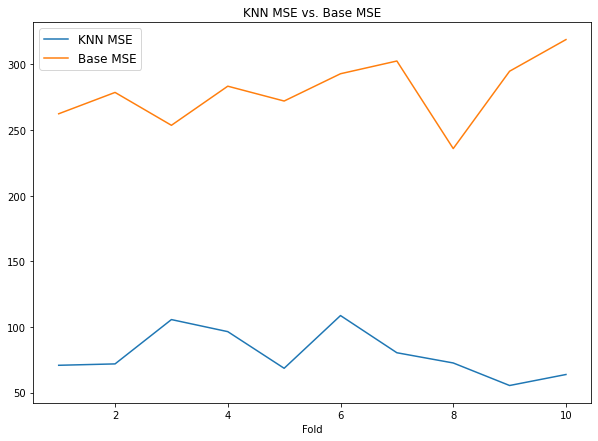

In [45]:
fig = plt.figure(figsize=(10, 7))
plt.plot(range(1,11),mse_knn_list, label='KNN MSE')
plt.plot(range(1,11),mse_base_list, label = 'Base MSE')
plt.xlabel("Fold")
plt.legend(fontsize=12)
plt.title('KNN MSE vs. Base MSE')
plt.show()

### Interpreting the results
I think it is important to step back before looking at any particular metrics and see what we have achieved by normalizing data. In general, normalizationis used in an effort to have the training data in a similar scale. It should also serve to improve the stability of the training model. However, knn should not particularly benefit from this transformation. The reason being that we are simply scaling the features but not necessarily choose a different set of $k$ neares neighbors as a result. Should  the neighbors change dramatically by normalizing, then the prediction value would significantly change. Yet, they do not. Therefore I do not expect a dramatic improvement from implementing these changes.

This is lack of dramatic improvement is shown in the average MSE exposed in the model. Using standard normalization, the $k=2$ model achieved an average MSE of $79.3377$ versus $79.4221$ without normalization. Although there is some improvement, I would say that it is somewhat negligible. Notice also that the Baseline MSE are unchanged, this is because the target variables are untouched and not normalized. 

## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.